In [1]:
# 브런치 스토리 자취 검색 크롤링
# ------------------2024-08-06
# -----------------made by 서연

In [6]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup as bs
import pyperclip
import time
from selenium.webdriver.common.action_chains import ActionChains
from tqdm import tqdm

In [7]:
driver = webdriver.Chrome()

In [8]:
driver.get("https://brunch.co.kr/search?q=%EC%9E%90%EC%B7%A8+%EB%B0%A5&type=article")

In [9]:
soup  = bs(driver.page_source, 'lxml')

In [10]:
height = driver.execute_script("return document.body.scrollHeight")

In [11]:
#무한 스크롤링
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break

    last_height = new_height

In [12]:
soup  = bs(driver.page_source, 'lxml')

In [13]:
url = soup.select('a', class_='link_post #post_list')

In [14]:
url_list = []
for i in url:
    url_list.append("https://brunch.co.kr" + i['href'])

In [15]:
len(url_list)

378

In [16]:
# 링크를 DataFrame으로 저장
df = pd.DataFrame(url_list, columns=['URL'])

# 'https://brunch.co.kr/@'로 시작하는 URL만 필터링
df_filtered = df[df['URL'].str.startswith('https://brunch.co.kr/@@')]

In [17]:
df_filtered

,URL
12,https://brunch.co.kr/@@3drv/1319
13,https://brunch.co.kr/@@6PPn/140
14,https://brunch.co.kr/@@cKMM/74
15,https://brunch.co.kr/@@8ZNF/18
16,https://brunch.co.kr/@@5YEt/69
...,...
336,https://brunch.co.kr/@@vkP/234
337,https://brunch.co.kr/@@56pC/303
338,https://brunch.co.kr/@@dIgt/21
339,https://brunch.co.kr/@@aegg/64


In [18]:
# 결과를 저장할 리스트
title_list = []
contents_list = []

# 데이터프레임에서 URL 추출
urls = df_filtered['URL'].tolist()

# 각 URL을 순회하여 제목과 내용 추출
for url in tqdm(urls):
    driver.get(url)
    time.sleep(0.5)  # 페이지 로드 대기

    try:
        # 제목 추출
        title_element = driver.find_element(By.CSS_SELECTOR, "h1.cover_title")
        title = title_element.text
        title_list.append(title)
        
        # 내용 추출
        soup = bs(driver.page_source, 'lxml')
        contents_element = soup.select_one('div.wrap_item.item_type_img')
        if contents_element:
            contents = contents_element.get_text(separator='\n', strip=True)
            contents_list.append(contents)
        else:
            contents_element = soup.select_one('div.wrap_body.text_align_left.finish_txt')
            if contents_element:
                contents = contents_element.get_text(separator='\n', strip=True)
                contents_list.append(contents)
            else:
                contents = '내용 없음'
                contents_list.append(contents)

    except Exception as e:
        print(f"Error processing URL {url}: {e}")
        title_list.append('제목 없음')
        contents_list.append('내용 없음')

100%|██████████| 329/329 [07:31<00:00,  1.37s/it]


In [19]:
brunchStory = pd.DataFrame(contents_list, columns=['contents'])

In [42]:
brunchStory.describe

<bound method NDFrame.describe of                                               contents
0                                                     
1                                    오랜만에 만들어 본 장조림 덮밥
2    일 주일에 두 번씩 내 집에 간다. 식탁 위에 널브러진 물건부터 원래있던 자리를 찾...
3    이렇게 살면 안 되겠구나. 작년 12월, 자취 7년 차. '자취(自炊)'라는 이름에...
4                                         출처 Pinterest
..                                                 ...
324  "애 없고 젊으니까 아직 새댁이네"\n라는 말을 들었다.\n그런데 옆에서 듣던 다른...
325  _\n남편이 결혼 전부터 하던 사업이 무너졌다. 결혼하며 들어와 살았던 집은 경매로...
326                                                   
327  오랜만에 집에서 차분하게 자리에 앉아 노트북을 열었습니다.\n오늘 낮에는 역시나 오...
328  왜 나는 어린 시절의 기억이 전체를 지배하고 있을까!\n어린 시절이라고 해야 기껏 ...

[329 rows x 1 columns]>

In [21]:
from konlpy.tag import Okt
okt = Okt()

In [32]:
stopwords = ['있다', '되다', '하다', '나', '는', '은', '이', '가', '을', '를', '에', '에서', 
             '에게', '한테', '과', '와', '아', '랑', '으로', '로', '께서', '이나', '이라', '이야', 
             '인가', '이야말로', '그리고', '그런데', '그래서', '그래도', '그러나', '그럼에도', '그러면', 
             '그러니까', '그러므로', '그러니까', '그렇게', '그렇지만', '그렇다면', '아니면', '아니라', 
             '그런', '이런', '그렇지', '그래', '저런', '이러한', '그러한', '저러한', '어떤', '이따', 
             '이래', '이렇게', '저렇게', '그따', '그래서', '아무', '전부', '가지', '갖고', '몇', 
             '무슨', '어느', '몇몇', '어떤', '어떻게', '어떤', '아무', '나', '우리', '당신', '자기', 
             '그녀', '저희', '하다', '되다', '않다', '없다', '있다', '되어다', '하고', '그러면', 
             '그래서', '이렇게', '저렇게', '요즘', '그것', '이것', '저것', '있다고', '그렇지만', '그래도',
            '수', '안녕하세요', '그', '내', '이다', '안녕하다', '아니다', '같다', '거', '것', '음식', '음식물', '보다',
            '오늘', '혹시', '안', '그렇다', '때', '어떻다', '먹다']

In [33]:
def okt_pos_tagging(string):
    pos_words = okt.pos(string, stem=True, norm=True)
    words = [word for word, tag in pos_words if tag in ['Noun', 'Verb', 'Adjective'] if word not in stopwords ]
    return words

In [34]:
cleaned_contents_list = []

for content in contents_list:
    # 공백 및 줄바꿈 제거
    cleaned_content = content.strip()  # 양쪽 공백 제거
    
    # 연속된 공백을 단일 공백으로 변환
    cleaned_content = ' '.join(cleaned_content.split())
    
    cleaned_contents_list.append(cleaned_content)

In [35]:
# 추출된 단어들을 저장할 리스트
extracted_words_list = []

# cleaned_contents_list에 있는 각 텍스트에 대해 okt_pos_tagging 함수 호출하여 추출된 단어들을 리스트에 저장
for text in cleaned_contents_list:
    extracted_words = okt_pos_tagging(text)
    extracted_words_list.append(extracted_words)

In [36]:
data = {"내용" : cleaned_contents_list, "추출된 단어" : extracted_words_list}

In [37]:
brunchStory_df = pd.DataFrame(data)

In [38]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

In [39]:
count_list = []

for words in extracted_words_list:
    count  = Counter(words)
    count.most_common(200) 
    count_list.append(count)

In [40]:
# 모든 Counter 객체를 합치기
total_counter = Counter()
for counter in count_list:
    total_counter += counter

<function matplotlib.pyplot.show(close=None, block=None)>

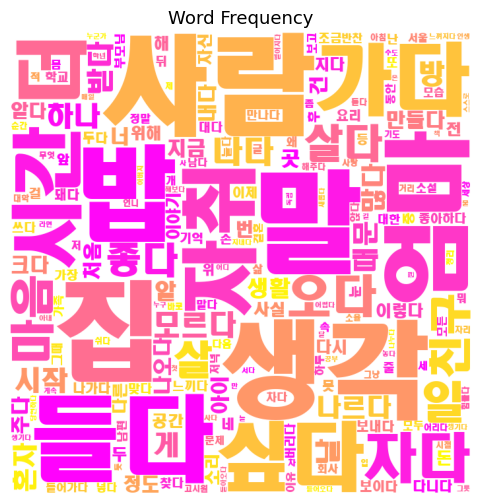

In [41]:
from wordcloud import WordCloud

# 한글 폰트 경로 설정
font_path = "'C:\Windows\Fonts\HMKMRHD.TTF"

# WordCloud 객체 생성
wordcloud = WordCloud(font_path=font_path,
                      width=700, 
                      height=700, 
                      background_color='white',
                      colormap='spring',
                      random_state=1).generate_from_frequencies(total_counter)

# 시각화
plt.figure(figsize=(6,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Frequency", size = 13) 
plt.show